# Content Moderation

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

- Model was trained on images belonging to 2 classes: neutral and porn
    - For this segregation, the shell scripts from the github link [nsfw_data_scrapper](https://github.com/alex000kim/nsfw_data_scraper/tree/master/scripts) as given are used.
    - Following scripts were run to obtain data:
        - 1_get_urls_.sh
        - 2_download_from_urls_.sh
        - 5_create_train_.sh
        - 6_create_test_.sh
- Images in train folder were segregated in these 2 classes _(porn and neutral)_ for training

In [51]:
data_dir = './nsfw_data_scraper-master/data/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['neutral', 'porn']


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train model

> **Note:** Pardon the interruption in training due to GPU heating (training time was about 6-7 hours)

In [54]:
epochs = 25
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, 'cm_model.pth')

Epoch 1/10.. Train loss: 2.093.. Test loss: 0.212.. Test accuracy: 0.939
Epoch 2/10.. Train loss: 0.425.. Test loss: 0.366.. Test accuracy: 0.833
Epoch 3/10.. Train loss: 0.272.. Test loss: 0.195.. Test accuracy: 0.921
Epoch 4/10.. Train loss: 0.199.. Test loss: 0.155.. Test accuracy: 0.941
Epoch 5/10.. Train loss: 0.177.. Test loss: 0.118.. Test accuracy: 0.952
Epoch 6/10.. Train loss: 0.209.. Test loss: 0.112.. Test accuracy: 0.957
Epoch 7/10.. Train loss: 0.203.. Test loss: 0.203.. Test accuracy: 0.923
Epoch 8/10.. Train loss: 0.227.. Test loss: 0.153.. Test accuracy: 0.945
Epoch 9/10.. Train loss: 0.164.. Test loss: 0.113.. Test accuracy: 0.957
Epoch 10/10.. Train loss: 0.149.. Test loss: 0.108.. Test accuracy: 0.958
Epoch 11/10.. Train loss: 0.157.. Test loss: 0.101.. Test accuracy: 0.961
Epoch 12/10.. Train loss: 0.102.. Test loss: 0.130.. Test accuracy: 0.949
Epoch 13/10.. Train loss: 0.152.. Test loss: 0.120.. Test accuracy: 0.952
Epoch 14/10.. Train loss: 0.131.. Test loss: 0.

KeyboardInterrupt: 

In [61]:
torch.save(model, 'cm_model.pth')

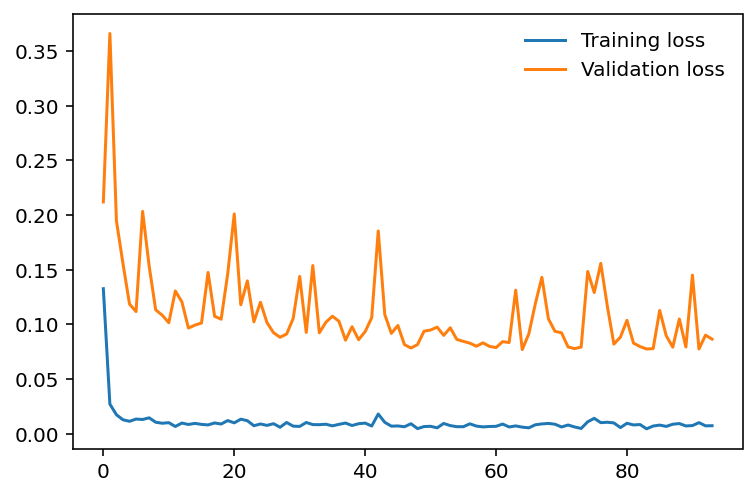

In [55]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Test model

In [5]:
data_dir = './nsfw_data_scraper-master/data/test'
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                     ])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cm_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
#     input_ = Variable(image_tensor)
    input_ = image_tensor.to(device)
    output = model(input_)
    index = output.data.cpu().numpy().argmax()
    return index

In [8]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

# Classification Report

In [16]:
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
y_true = []
y_pred = []

to_pil = transforms.ToPILImage()
images, labels = get_random_images(500)


In [20]:

for ii in range(len(images)):
#     print(ii)
    image = to_pil(images[ii])
    index = predict_image(image)
    y_true.append(labels[ii])
    y_pred.append(index)


In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))
print()

# Accuracy
from sklearn.metrics import accuracy_score
print('Accuracy Score:')
print(accuracy_score(y_true, y_pred))
print()

# Method 3: Classification report [BONUS]
from sklearn.metrics import classification_report
print('Classification report:')
print(classification_report(y_true, y_pred, target_names=classes))

Confusion matrix:
[[236  12]
 [  3 249]]

Accuracy Score:
0.97

Classification report:
              precision    recall  f1-score   support

     neutral       0.99      0.95      0.97       248
        porn       0.95      0.99      0.97       252

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



In [19]:
# data = datasets.ImageFolder(data_dir, transform=test_transforms)
# classes = data.classes
    
# to_pil = transforms.ToPILImage()
# images, labels = get_random_images(5)
# fig=plt.figure(figsize=(20,20))
# for ii in range(len(images)):
#     image = to_pil(images[ii])
#     index = predict_image(image)
#     sub = fig.add_subplot(1, len(images), ii+1)
#     res = int(labels[ii]) == index
#     sub.set_title(str(classes[index]) + ":" + str(res))
#     plt.axis('off')
#     plt.imshow(image)
# plt.show()

# Process video file

> **Note:** To execute independent video file, run the cells below this point only.

In [4]:
import numpy as np
import argparse

import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cm_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                     ])

In [5]:
def predict_image(image):
    # Outputs index -
    # 0 = neutral and 1 = pornographic
    
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_ = image_tensor.to(device)
    output = model(input_)
    index = output.data.cpu().numpy().argmax()
    return index

In [16]:
if __name__ == '__main__':

    # Input video filename
    input_video = 'input.mp4'
    
    cap = cv2.VideoCapture(input_video)
    fps = cap.get(cv2.CAP_PROP_FPS)

    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    count = 0
    start_time = 0
    flag = 0
    while(cap.isOpened()):

        ret, frame = cap.read()
        if ret == True:
            count += 1
            timestamp = round(count/fps, 2)
            pred_idx = predict_image(Image.fromarray(frame))

            if pred_idx == 1:
                start_time = timestamp
                flag = 1
            elif ((pred_idx == 0) & (flag == 1)):
                flag = 0
                print('Unsuitable content between timestamps {} seconds and {} seconds.'.format(start_time, 
                                                                                                timestamp))
            else:
                pass

            # Display the resulting frame
            cv2.imshow('Frame',frame)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        else: 
            break

    cap.release()
    cv2.destroyAllWindows()
